In [1]:
import numpy as np
import pandas as pd
import kagglehub
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
#  from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import DropMissingData
from feature_engine.encoding import OneHotEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
import Generate_BoxPlots as generate_boxplots
import DataCleaning as DataCleaningEffect
import FeatureEngineeringAnalysis as FeatureEngineeringAnalysis

h:\VScode\PoliticalDonations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Data

In [2]:
df = pd.read_csv('Donations_accepted_by_political_parties.csv', dtype={
    'index': 'int64',
    'ECRef' : 'object',
    'RegulatedEntityName': 'object',
    'RegulatedEntityType': 'object',
    'Value': 'string',
    "AcceptedDate": 'string',
    "AccountingUnitName": 'string',
    "DonorName": 'object',
    "AccountingUnitsAsCentralParty": 'bool',
    'IsSponsorship': 'bool',
    'DonorStatus': 'object',
    'RegulatedDoneeType': 'object',
    'CompanyRegistrationNumber': 'string',
    'Postcode': 'string',
    'DonationType': 'object',
    'NatureOfDonation': 'object',
    'PurposeOfVisit': 'string',
    'DonationAction': 'string',
    'ReceivedDate': 'string',
    'ReportedDate': 'string',
    'IsReportedPrePoll': 'string',
    'ReportingPeriodName': 'string',
    'IsBequest': 'bool',
    'IsAggregation': 'bool',
    'RegulatedEntityId': 'object',
    'AccountingUnitId': 'string',
    'DonorId': 'object',
    'CampaigningName': 'string',
    'RegisterName': 'string',
    'IsIrishSource': 'string'
    },index_col="index")

# DataSummary
def DataSummary(dfTest):

    NonObject = dfTest.select_dtypes(exclude=['object', 'string', 'datetime64']).columns
    summary_df = pd.DataFrame({
        'DataType': dfTest.dtypes,
        'UniqueValues': dfTest.nunique(),
        'RowsWithData': len(dfTest)-dfTest.isnull().sum(),
        'NullValues':dfTest.isnull().sum(),
        'SkewScore':dfTest[NonObject].skew(),
        'Kurtosis':dfTest[NonObject].kurtosis()
    }).reset_index().rename(columns={'index': 'Column'})
    return summary_df

print(DataSummary(df))


                           Column        DataType  UniqueValues  RowsWithData  \
0                    AcceptedDate  string[python]          6265         64265   
1                AccountingUnitId  string[python]          2185         36355   
2              AccountingUnitName  string[python]          1856         56957   
3   AccountingUnitsAsCentralParty            bool             2         65278   
4                 CampaigningName  string[python]             3             5   
5       CompanyRegistrationNumber  string[python]          3558         11480   
6                  DonationAction  string[python]             3           283   
7                    DonationType          object             9         65278   
8                         DonorId          object         44739         65197   
9                       DonorName          object         19010         65193   
10                    DonorStatus          object            13         65220   
11                          

In [3]:
# Remove Currency sign of Value and convert to Float
df['Value'] = df['Value'].replace({'\£': '', ',': ''}, regex=True).astype(float)

# create Value_Category based on 10 equal volumed buckets
Groupings = 10
Value_Category_two = pd.qcut(df['Value'],q=Groupings)
df = pd.concat([Value_Category_two, df],axis=1, join="inner")
df.columns.values[0]='Value_Category'
# set Value_Category to Object
df['Value_Category'] = df['Value_Category'].astype(object)

# Fill blank ReceivedDate with ReportedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportedDate'])
# Fill blank ReceivedDate with AcceptedDate
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['AcceptedDate'])

# convert Received date to Date Format
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y', errors='coerce')

# Convert 'ReportingPeriodName' to datetime if it contains dates at the e
df['ReportingPeriodName_Date'] = pd.to_datetime(
    df['ReportingPeriodName'].str.strip().str[-10:],
    dayfirst=True,
    format='mixed', 
    errors='coerce'
)
# Fill missing 'ReceivedDate' with extracted dates from 'ReportingPeriodName'
df['ReceivedDate'] = df['ReceivedDate'].fillna(df['ReportingPeriodName_Date'])

# Append YearReceived column 
df['YearReceived'] = round(df['ReceivedDate'].dt.year)
# Append MonthReceived column 
df['MonthReceived'] = round(df['ReceivedDate'].dt.month)
# Create YearMonthReceived Column
df['YearMonthReceived'] = round(df['YearReceived']*100 +df['MonthReceived'])

 
# Replace Nulls in NatureOfDonation
# Fill missing 'NatureOfDonation' with extracted dates from 'ReportingPeriodName'
# if IsBequest is true then set Blank Nature of Donations to Is A Bequest
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsBequest'].apply(lambda x: 'Is A Bequest' if x else None))
# if isAggregation is true then set Blank Nature of Donations to AAggregated Donation
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsAggregation'].apply(lambda x: 'Aggregated Donation' if x else None))
# if IsSponsorship true the set Blank Nature of Donations to SponsorShip
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['IsSponsorship'].apply(lambda x: 'Sponsorship' if x else None))
# Update NatureOfDonation to donation to doneetype
df['NatureOfDonation'] = df['NatureOfDonation'].fillna(df['RegulatedDoneeType'].apply(lambda x: f'Donation to {x}' if x else None))
# Replace Donationm to nan in NatureOfDonation with Other
df['NatureOfDonation'] = df['NatureOfDonation'].replace({'\Donation to nan': 'Other', 'Other Payment': 'Other'}, regex=True)


# drop unrequired Columns
df = df.drop(['IsIrishSource', 'RegisterName', 'CampaigningName','AccountingUnitName','AccountingUnitsAsCentralParty','AccountingUnitId','ReportedDate','AcceptedDate','PurposeOfVisit','IsReportedPrePoll', 'ReportingPeriodName_Date'], axis=1)
# drop blank ReceivedDate, DonorID or regulatedEntityName
df = df.dropna(subset = ['ReceivedDate', 'RegulatedEntityName','DonorId','DonorName'])

#drop rows with a DonationAction type
df = df[df.DonationAction.isna()]
#drop rows where DonationType = Impremissible Donor Impermissible Donor  
df = df[df.DonationType!='Impermissible Donor']
#drop rows where donorStatus is 'Impermissible Donor'
df = df[df.DonorStatus!='Impermissible Donor']


Review DonorStatus, DonationAction, DonationType, NatureOfDonation

In [6]:
# Create a DataFrame with the sum, count and mean of the donations for each RegulatedEntityName
RegulatedEntity_df = df.groupby('RegulatedEntityName').agg({'Value': ['sum', 'count', 'mean']})
# Rename columns
RegulatedEntity_df.columns = [ 'DonationsValue', 'DonationEvents', 'DonationMean']

# Define a function to set the category
def RegulatedEntityGroup(RegulatedEntityNameVar):

    # Define Dictionary with grouped values
    RegEntityGrouping = {0:'No Relevant Donations', 1: 'Single Donation Entity', 50: 'Very Small Entity', 100: 'Small Entity', 1000: 'Medium Entity', float('inf'): RegulatedEntityNameVar}
    # Select all relevant donation events for specified Entity Name    
    RE_Events = RegulatedEntity_df[RegulatedEntity_df.index == RegulatedEntityNameVar]
    #Compare Count of events to rangelimits in Dictionary and return Category
    for rangeLimit, category in RegEntityGrouping.items():
        if RE_Events.DonationEvents.agg(sum) <= rangeLimit:
            return category

# Apply the function to create a new column
df['RegEntity_Group'] = df.RegulatedEntityName.apply(RegulatedEntityGroup)
# Summary of update from above
df.groupby(['RegEntity_Group']).agg({'Value': ['sum', 'count', 'mean']})

Value                     
                                          sum  count          mean
RegEntity_Group                                                   
Conservative and Unionist Party  4.190993e+08  20252  20694.220309
Green Party                      4.958368e+06   1039   4772.250472
Labour Party                     3.574867e+08  18117  19732.112444
Liberal Democrats                9.661835e+07  12061   8010.807411
Medium Entity                    9.877529e+07   3061  32268.960872
Single Donation Entity           2.892832e+06    482   6001.725809
Small Entity                     1.744590e+07   1552  11240.915909
UK Independence Party (UKIP)     1.774309e+07   1801   9851.797274
Very Small Entity                7.546376e+07   6570  11486.112865

In [7]:
## module to calculate diffence in a definable period between a given date and the nearest election date, either days till ("DaysTill"), or days since ("DaysSince")   
## refences the ElectionDateAscend variable which currently contains UK election dates from 2001 to 2024 - these can be changed to any country's election dates as required
ElectionDates = ['2001/06/07 00:00:00','2005/05/05 00:00:00','2010/06/05 00:00:00', '2015/07/05 00:00:00', '2017/07/05 00:00:00', '2019/12/12 00:00:00', '2024/07/04 00:00:00']
## create ascending list
ElectionDatesAscend = sorted(ElectionDates, reverse=False)
## creates descending list
ElectionDatesDescend = sorted(ElectionDates, reverse=True)

def GenElectionRelation2(R_Date, divisor, direction):
    for ED in ElectionDatesAscend:
        R_Date2 = R_Date
        # R_Date2 = dt.datetime.strptime(R_Date, '%Y/%m/%d %H:%M:%S')
        ED2 = dt.datetime.strptime(ED, '%Y/%m/%d %H:%M:%S')
        if R_Date2 <= ED2 and direction=="DaysTill":
            DaysDiff = (ED2 - R_Date2)
            delta = math.ceil(DaysDiff.days / divisor)
            return delta
        elif R_Date2 >= ED2 and direction=="DaysSince":
            DaysDiff = (R_Date2 - ED2)
            delta = math.ceil(DaysDiff.days / divisor)
            return delta
        else:
            pass
    return 0

## example of how to apply the function to a dataframe
## df['DaysTillNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysTill")

In [8]:
# append Election Date diffentials to DataFrame
df['DaysToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysTill")

df['WeeksToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=7, direction="DaysTill")

df['QtrsToNextElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=91, direction="DaysTill")

df['DaysSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=1, direction="DaysSince")

df['WeeksSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=7, direction="DaysSince")

df['QtrsSinceLastElection'] = df['ReceivedDate'].apply(GenElectionRelation2, divisor=91, direction="DaysSince")



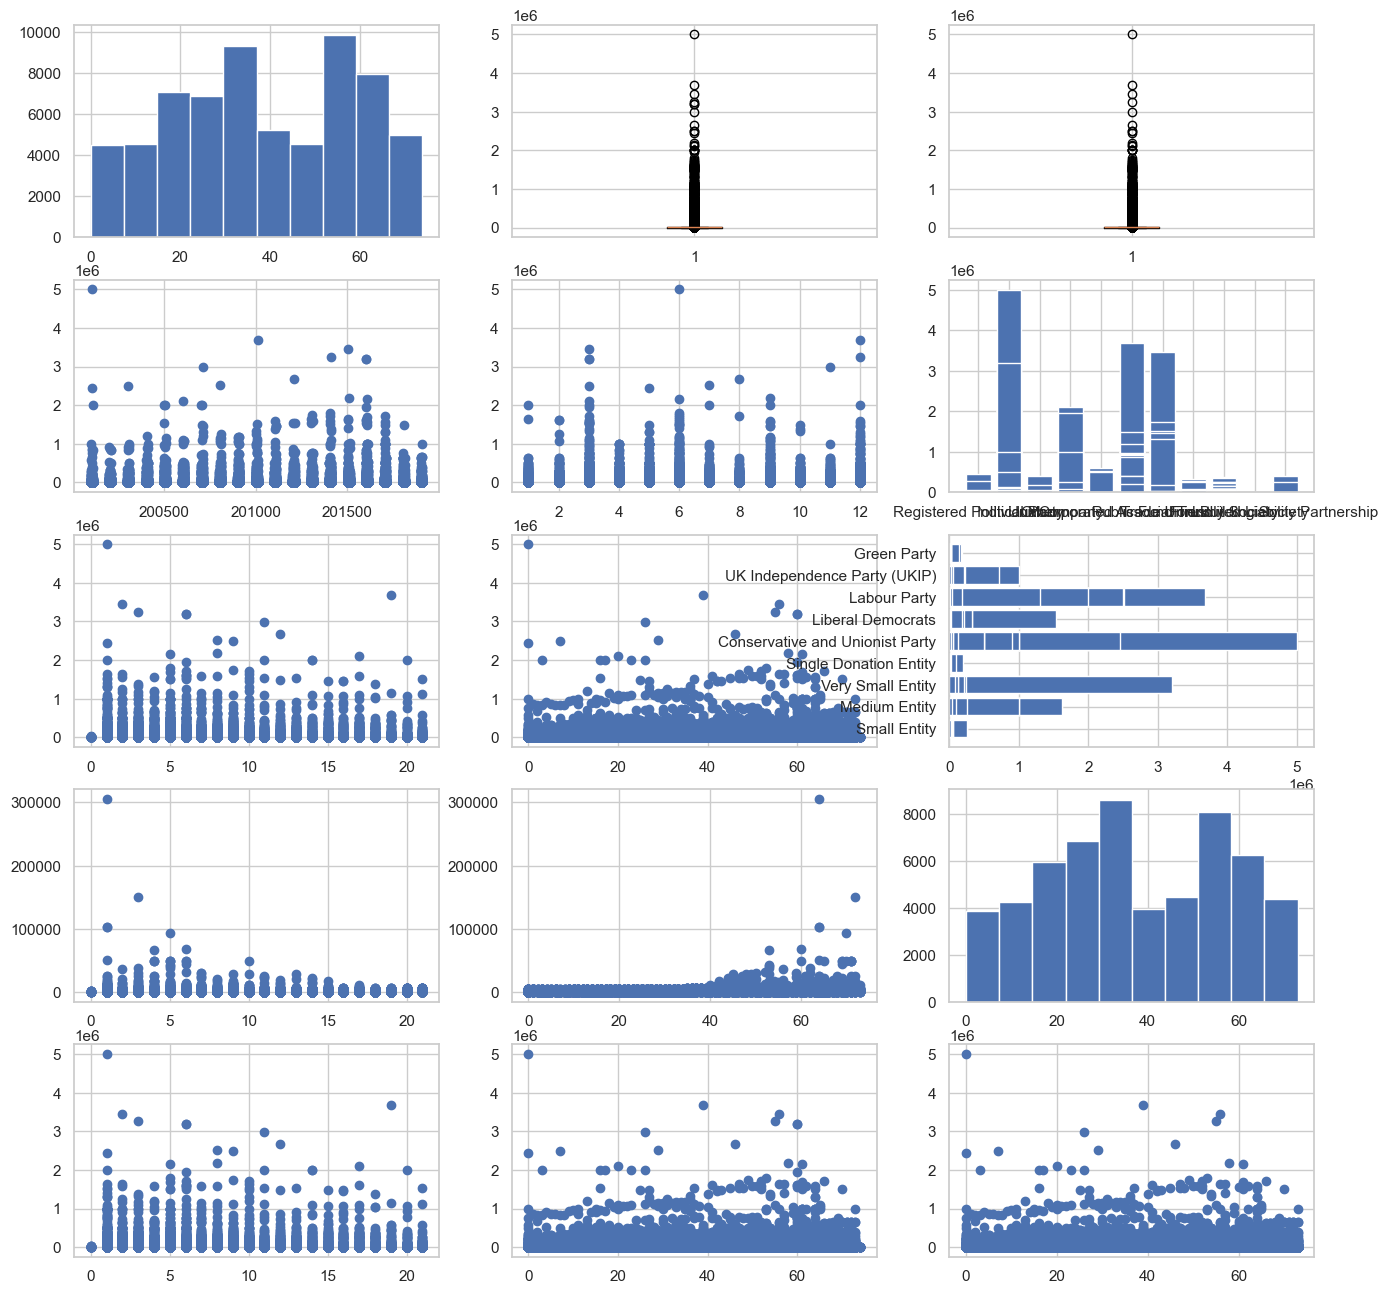

In [9]:
## Visualisations of the data
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,16))

axes[0,0].hist(df["QtrsSinceLastElection"])
axes[0,1].boxplot(x=df['Value'] )
axes[0,2].boxplot(data=df[df['RegulatedEntityType']=='Political Party'], x='Value')
axes[1,0].scatter(x=df['YearMonthReceived'], y =df['Value'])
axes[1,1].scatter(x=df['MonthReceived'], y=df['Value'])
axes[1,2].bar(x=df['DonorStatus'], height=df['Value'])
axes[2,0].scatter(x=df['QtrsToNextElection'], y=df['Value'])
axes[2,1].scatter(x=df['QtrsSinceLastElection'], y=df['Value'])
axes[2,2].barh(y=df['RegEntity_Group'], width = df['Value'])
axes[3,0].scatter(data=df[df['IsAggregation']==True], x='QtrsToNextElection', y='Value')
axes[3,1].scatter(data=df[df['IsAggregation']==True], x='QtrsSinceLastElection', y='Value')
axes[4,0].scatter(data=df[df['IsAggregation']==False], x='QtrsToNextElection', y='Value')
axes[4,1].scatter(data=df[df['IsAggregation']==False], x='QtrsSinceLastElection', y='Value')
axes[3,2].hist(data=df[df['RegulatedEntityType']=='Political Party'], x='QtrsSinceLastElection')
axes[4,2].scatter(data=df[df['RegulatedEntityType']=='Political Party'], x='QtrsSinceLastElection', y='Value')
plt.show()


In [11]:
# drop unrequired Columns
df = df.drop(['CompanyRegistrationNumber', 
            'DonationAction',
             'Postcode', 
             'RegulatedDoneeType',
             'ECRef', 
             'IsAggregation', 
             'IsBequest', 
             'IsSponsorship', 
             'ReportingPeriodName',
             'RegulatedEntityId',
             'RegulatedEntityName',
             'RegulatedEntityType',
             'DonorId'
             ], axis=1)

In [12]:
# DataSummary post clean
# list all non obect fields
NonObject = df.select_dtypes(exclude=['object', 'string', 'datetime64']).columns

summary_df2 = pd.DataFrame({
    'DataType': df.dtypes,
    'UniqueValues': df.nunique(),
    'RowsWithData': len(df)-df.isnull().sum(),
    'NullValues':df.isnull().sum(),
    'SkewScore':df[NonObject].skew(),
    'Kurtosis':df[NonObject].kurtosis()
}).reset_index().rename(columns={'index': 'Column'})
print(df.describe())
summary_df2

              Value                   ReceivedDate  YearReceived  \
count  6.493500e+04                          64935  64935.000000   
mean   1.679346e+04  2010-12-06 09:44:36.257796096   2010.428582   
min    0.000000e+00            2001-01-01 00:00:00   2001.000000   
25%    1.550000e+03            2006-12-13 00:00:00   2006.000000   
50%    3.000000e+03            2010-06-23 00:00:00   2010.000000   
75%    9.000000e+03            2015-04-01 00:00:00   2015.000000   
max    5.000000e+06            2019-09-02 00:00:00   2019.000000   
std    8.398893e+04                            NaN      5.070271   

       MonthReceived  YearMonthReceived  DaysToNextElection  \
count   64935.000000       64935.000000        64935.000000   
mean        6.504859      201049.363102          626.230646   
min         1.000000      200101.000000            0.000000   
25%         4.000000      200612.000000          186.000000   
50%         6.000000      201006.000000          491.000000   
75%      

,Column,DataType,UniqueValues,RowsWithData,NullValues,SkewScore,Kurtosis
0,DaysSinceLastElection,int64,5945,64935,0,-0.110709,-1.121681
1,DaysToNextElection,int64,1845,64935,0,0.723396,-0.567946
2,DonationType,object,6,64935,0,NaN,NaN
3,DonorName,object,18787,64935,0,NaN,NaN
4,DonorStatus,object,11,64935,0,NaN,NaN
5,MonthReceived,int32,12,64935,0,0.219931,-1.193447
6,NatureOfDonation,object,33,64935,0,NaN,NaN
7,QtrsSinceLastElection,int64,75,64935,0,-0.115552,-1.114566
8,QtrsToNextElection,int64,22,64935,0,0.729141,-0.551337
9,ReceivedDate,datetime64[ns],6057,64935,0,NaN,NaN


* Variable Analyzed: DonationType
* Applied transformation: ['DonationType_ordinal_encoder'] 



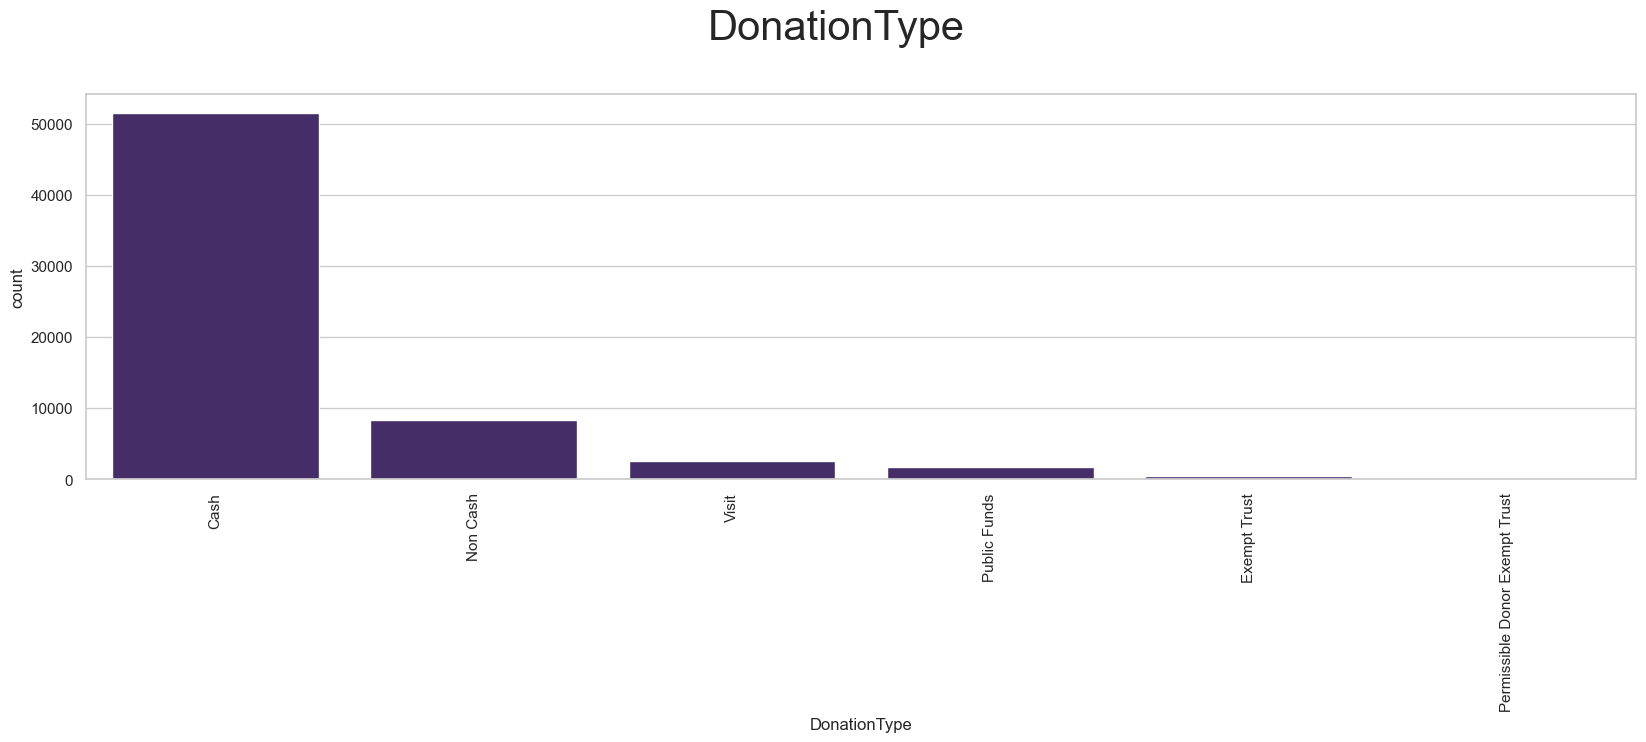

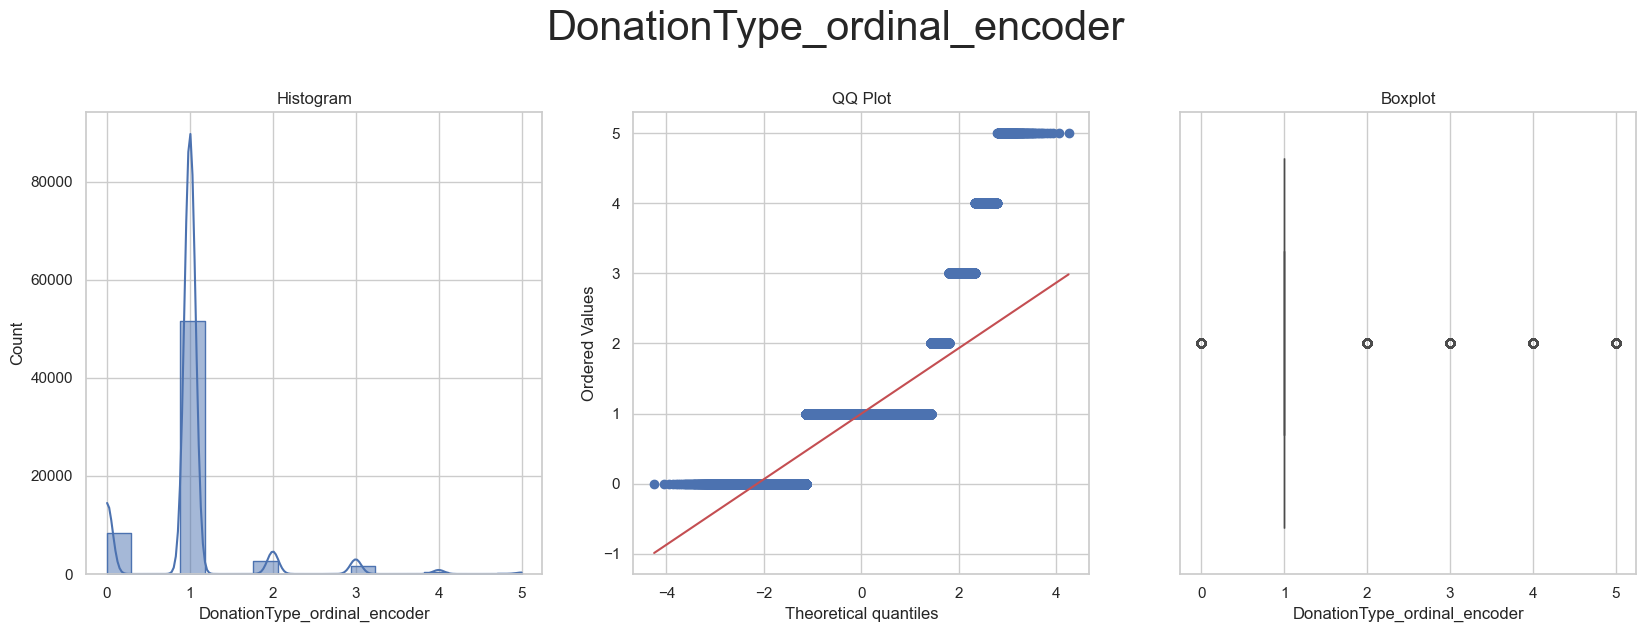



* Variable Analyzed: DonorStatus
* Applied transformation: ['DonorStatus_ordinal_encoder'] 



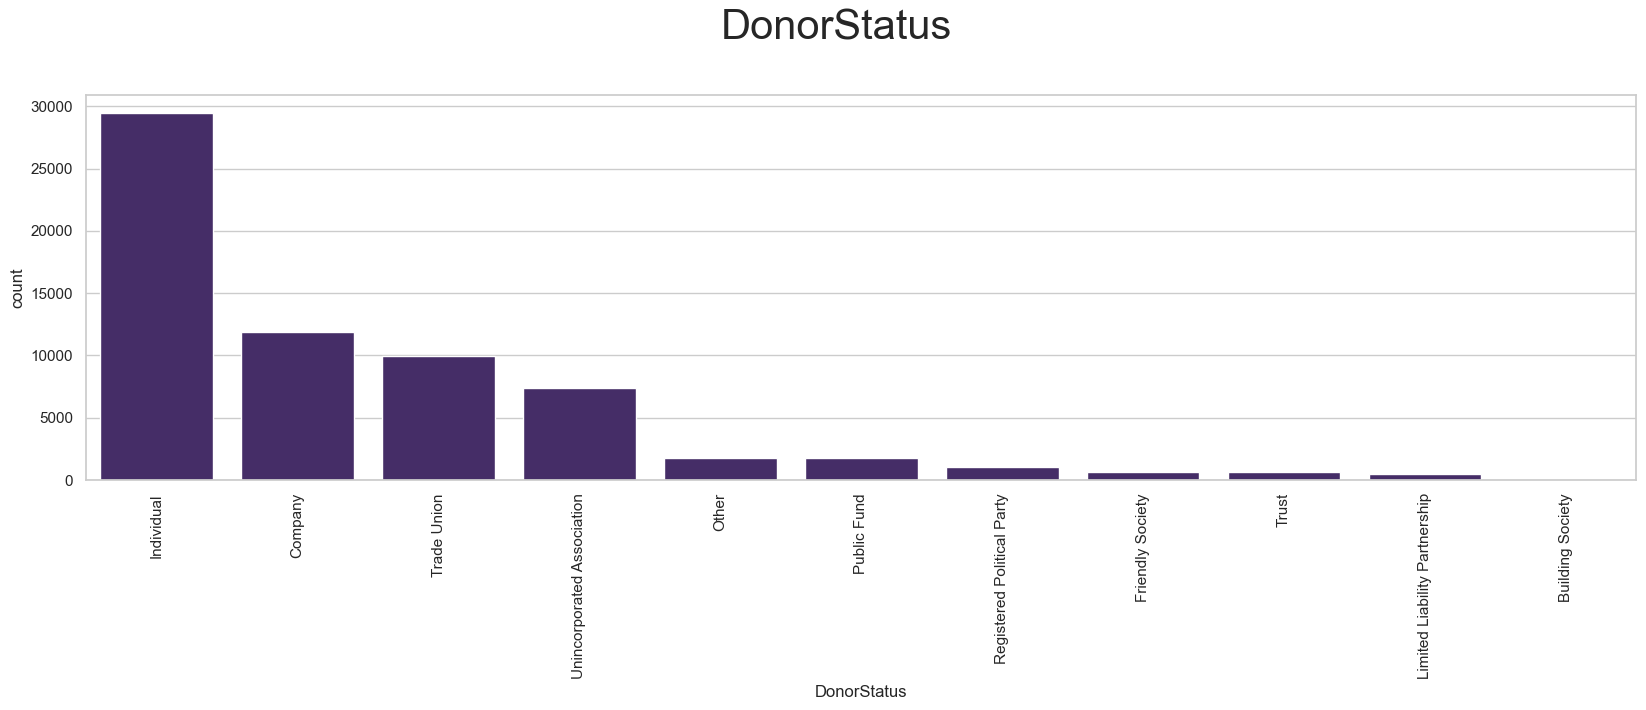

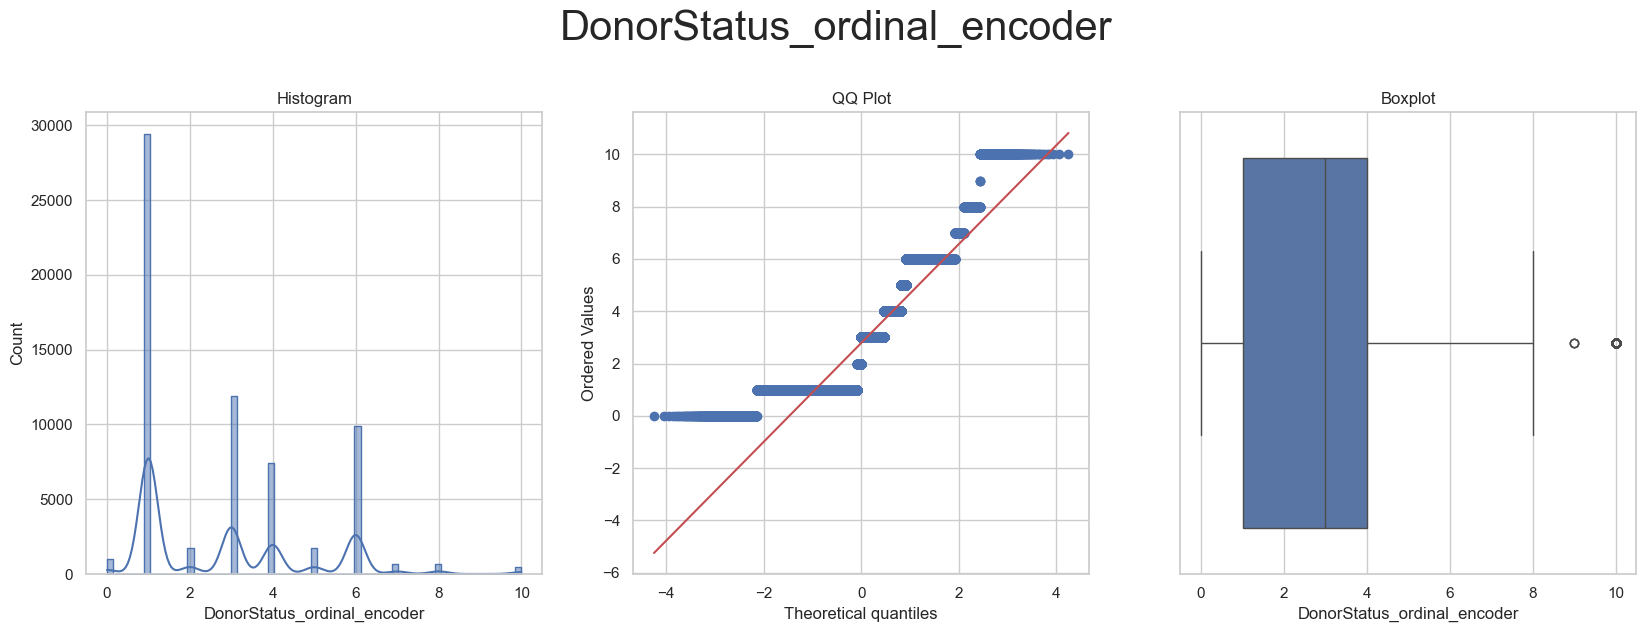



* Variable Analyzed: NatureOfDonation
* Applied transformation: ['NatureOfDonation_ordinal_encoder'] 



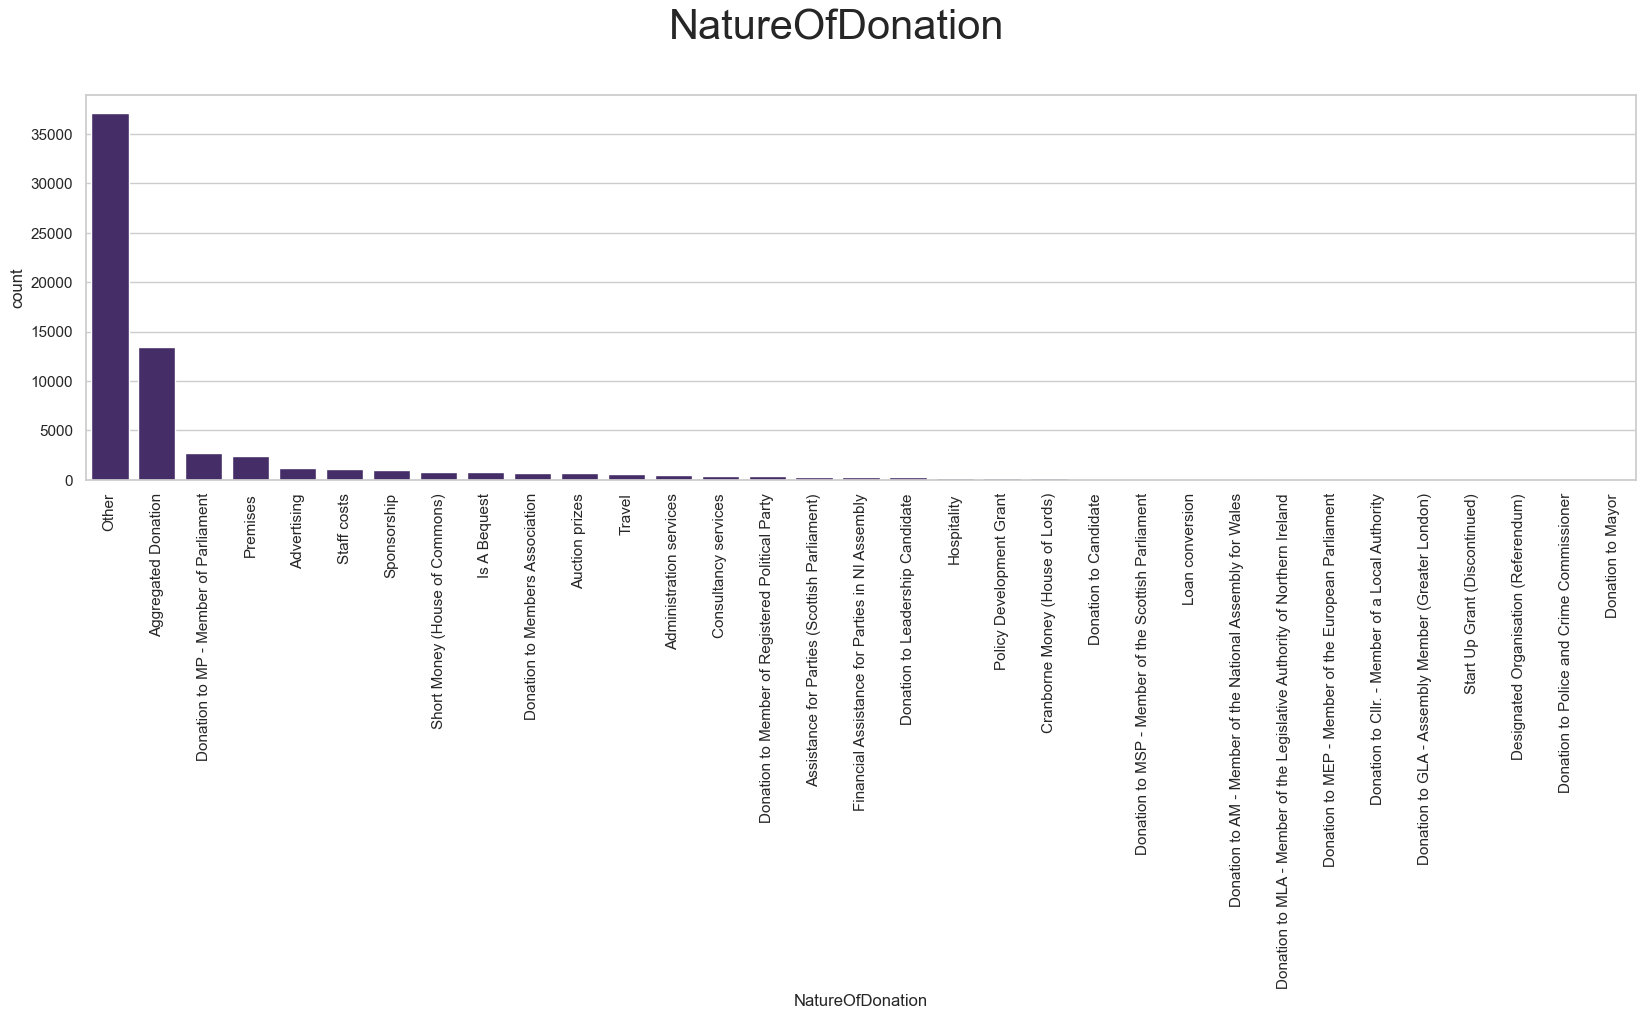

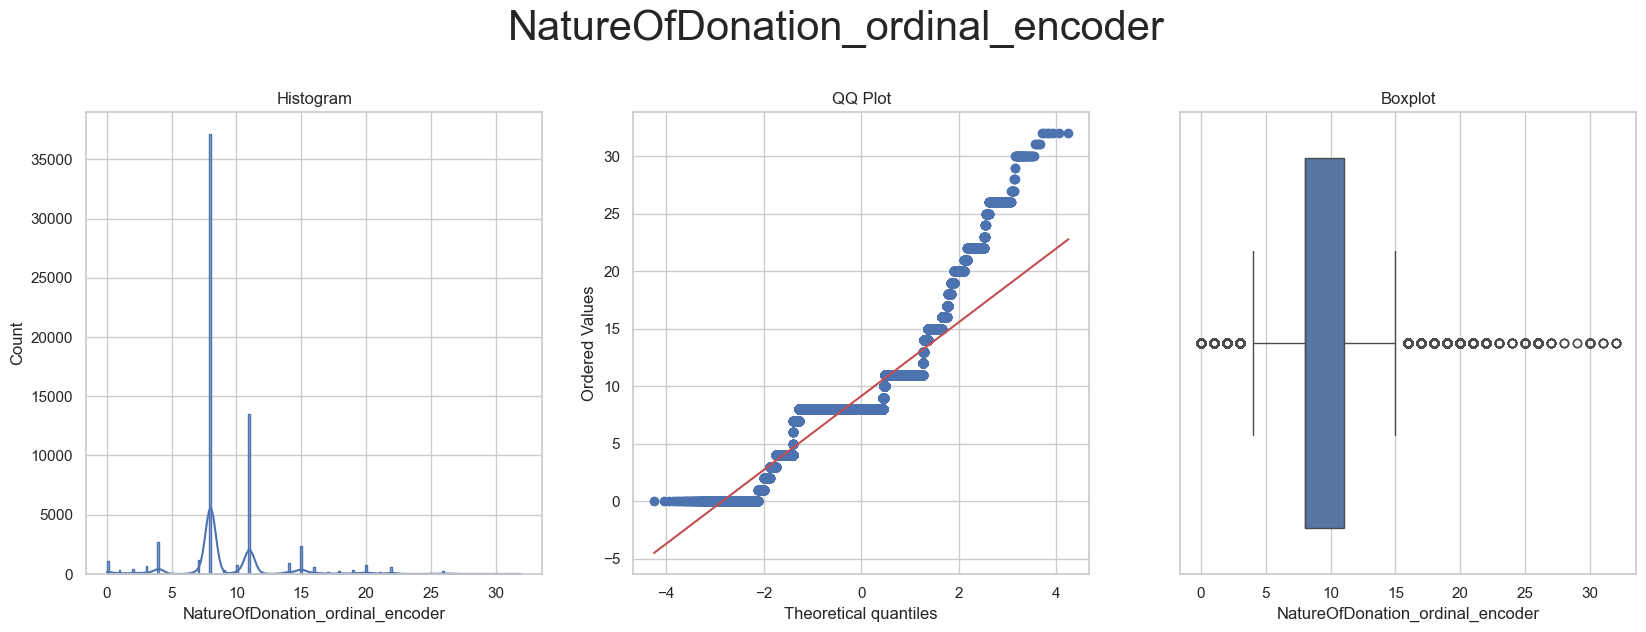



* Variable Analyzed: RegEntity_Group
* Applied transformation: ['RegEntity_Group_ordinal_encoder'] 



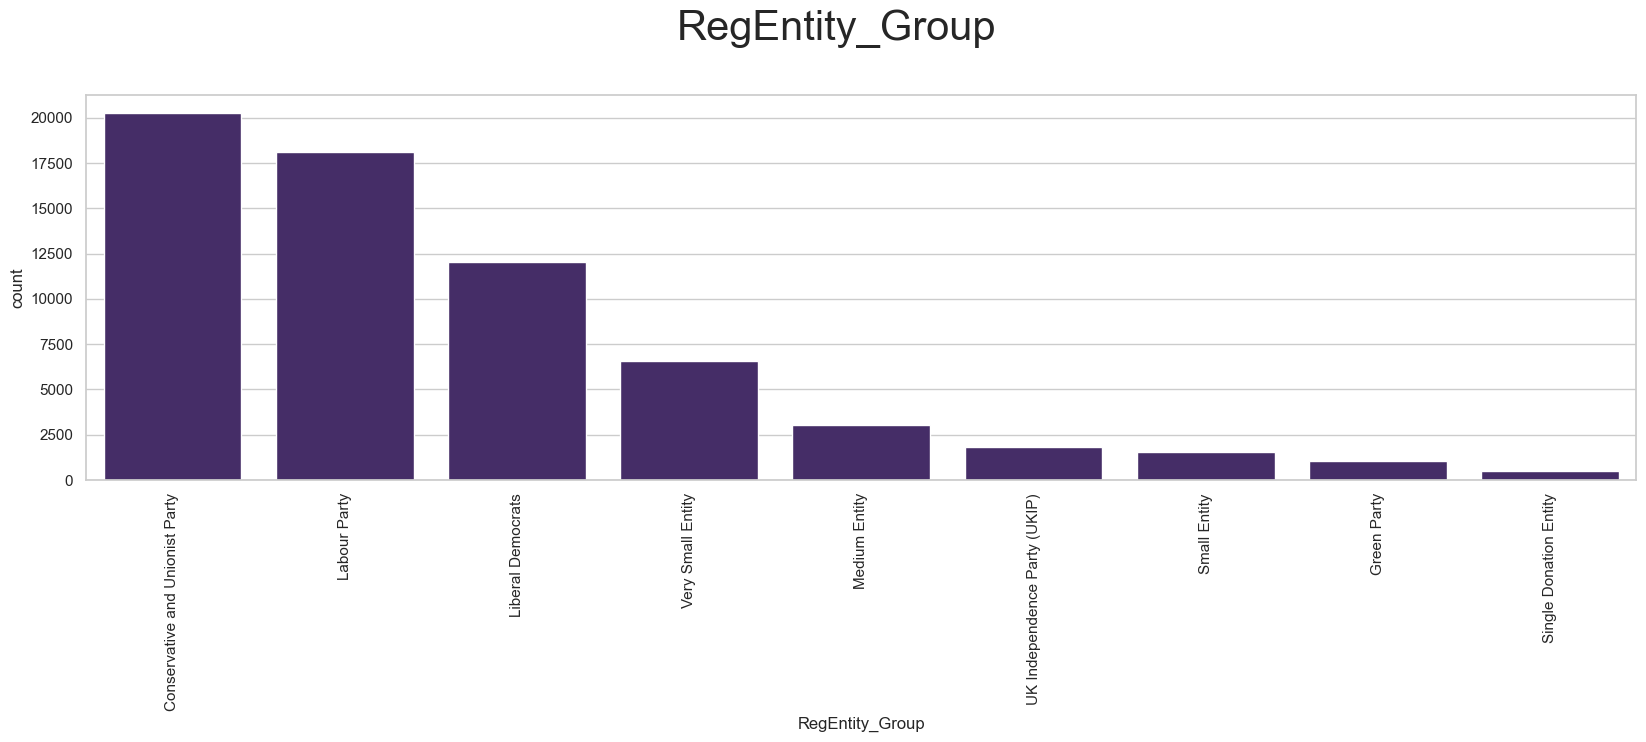

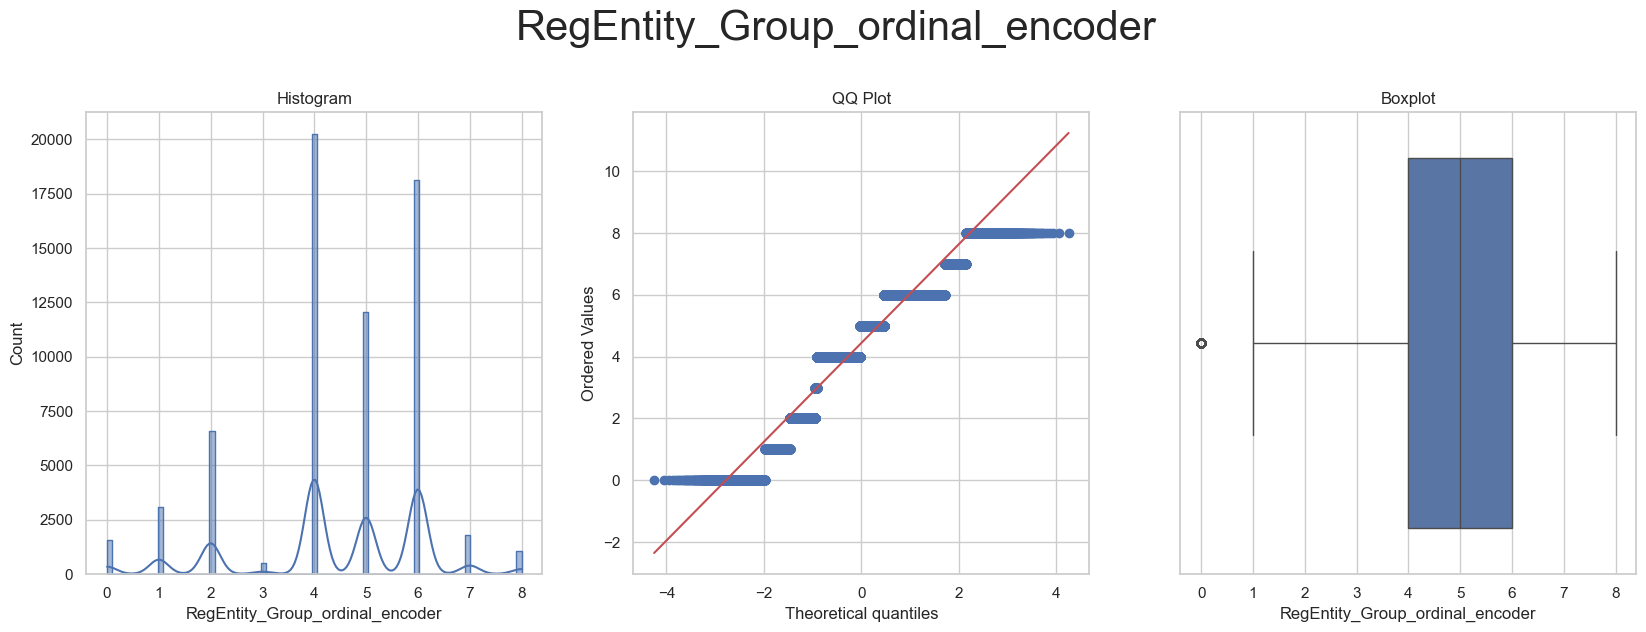



* Variable Analyzed: Value_Category
* Applied transformation: ['Value_Category_ordinal_encoder'] 



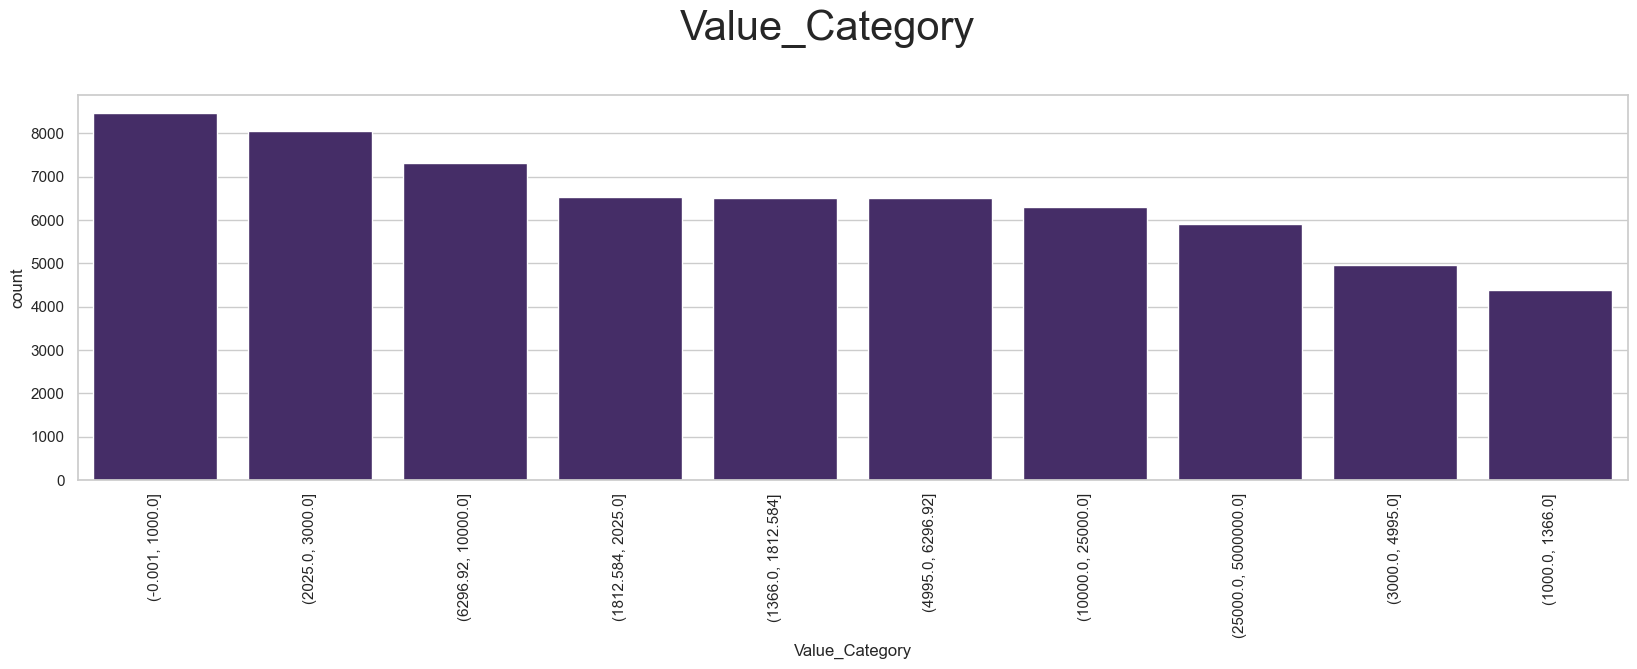

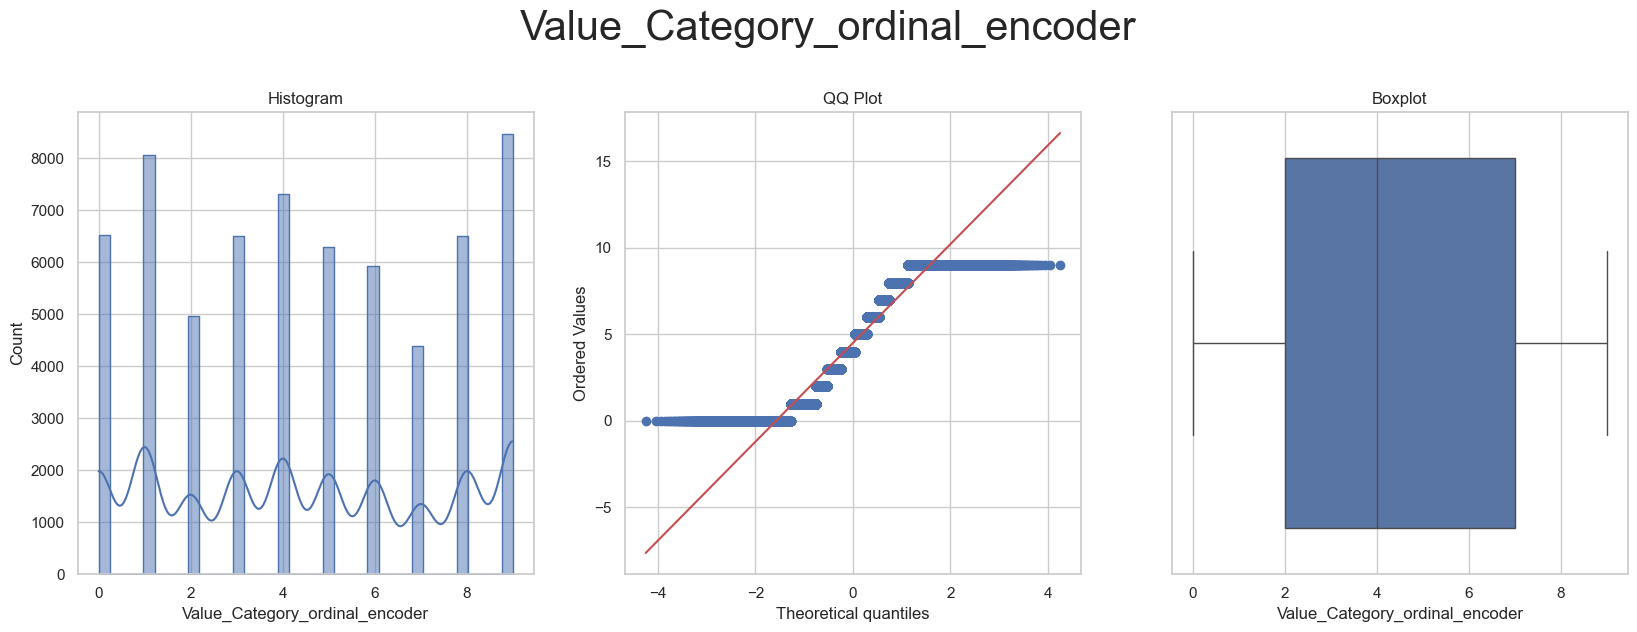

In [14]:
## Variable Engineering analysis
variables_engineering= ['DonationType',
    'DonorStatus',
    'NatureOfDonation',
    'RegEntity_Group', 
    'Value_Category'
    ]
df_engineering = df[variables_engineering].copy()
# 'numerical', 'ordinal_encoder',  'outlier_winsorizer'
df_engineering = FeatureEngineeringAnalysis.FeatureEngineeringAnalysis(df=df_engineering.dropna(),analysis_type='ordinal_encoder')

In [15]:
# Start to build machine learning model - to forcast Regulated Entity Group receiving payment 
#  based on donor(status, Type, Name, Donor Regulatory Status) qtrs since last election, value of donation, wether it was a bequest,
#  wether it was an aggregation, Nature Of Donation

le=LabelEncoder()

df.sort_values(['NatureOfDonation', 'DonorStatus', 'DonationType'])

df['Value_Category_code'] = le.fit_transform(df['Value_Category'])
df['DonorName_code'] = le.fit_transform(df['DonorName'])
df['DonorStatus_code'] = le.fit_transform(df['DonorStatus'])
df['DonationType_code'] = le.fit_transform(df['DonationType'])
df['NatureOfDonation_code'] = le.fit_transform(df['NatureOfDonation'])
df['RegEntity_Group_code'] =  le.fit_transform(df['RegEntity_Group'])

#Apply YeoJohnsonTransformer to Value
df['value_original']=df['Value']

ytf = YeoJohnsonTransformer(variables = ['Value'])

ytf.fit(df)

ytf.lambda_dict_

df=ytf.transform(df)

In [16]:
## First ML model - Decision Tree Regressor

X_train, X_test, y_train, y_test =  train_test_split(
            df.drop(labels=["RegEntity_Group_code","value_original","RegEntity_Group","Value_Category",  "DonorName", "DonorStatus", "DonationType", "NatureOfDonation"], axis=1),
            df["RegEntity_Group_code"],
            test_size=0.3,
            random_state=0
            )


In [27]:
## Decision Tree Regressor using - Value, QtrsSinceLastElection, Value_Category_code, DonorName_code, DonorStatus_code, DonationType_code, NatureOfDonation_code as Features
model_data = df

# Create Target Object Y
y= model_data['RegEntity_Group_code']

features = ['Value', 'QtrsSinceLastElection', 'Value_Category_code', 'DonorName_code', 'DonorStatus_code', 'DonationType_code','NatureOfDonation_code']

X = model_data[features]
# split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
DonationRecipient = DecisionTreeRegressor()
# Fit Model
DonationRecipient.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = DonationRecipient.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {}".format(val_mae))
print("MAPE when not specifying max_leaf_nodes: {}".format(val_mae/val_y.mean()))

# Using best value for max_leaf_nodes
DonationRecipient = DecisionTreeRegressor(max_leaf_nodes=2000, random_state=1)
DonationRecipient.fit(train_X, train_y)
val_predictions = DonationRecipient.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {}".format(val_mae))
print("MAPE when max_leaf_nodes = 2000: {}".format(val_mae/val_y.mean()))

## Machine learning Model 2 - Random Forest Regressor
# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(train_X, train_y)
rf_preds = rf_model.predict(val_X)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_y, rf_preds)
print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))
print("MAPE : {}".format(rf_val_mae/val_y.mean()))
## MAE Based on Integerised Predictions.
rf_preds2 = np.floor(0.5 + rf_preds)
rf_val_mae2 = mean_absolute_error(val_y, rf_preds2)
print("Validation integised MAE for Random Forest Model: {}".format(rf_val_mae2))
print("Integised MAPE : {}".format(rf_val_mae2/val_y.mean()))


Validation MAE when not specifying max_leaf_nodes: 0.8060775047312924
MAPE when not specifying max_leaf_nodes: 0.32118850846320257
Validation MAE for best value of max_leaf_nodes: 0.9359394776223788
MAPE when max_leaf_nodes = 2000: 0.37293312747831964
Validation MAE for Random Forest Model: 0.789487251392931
MAPE : 0.3145779794588592
Validation integised MAE for Random Forest Model: 0.7546507330294444
Integised MAPE : 0.3006970693633106


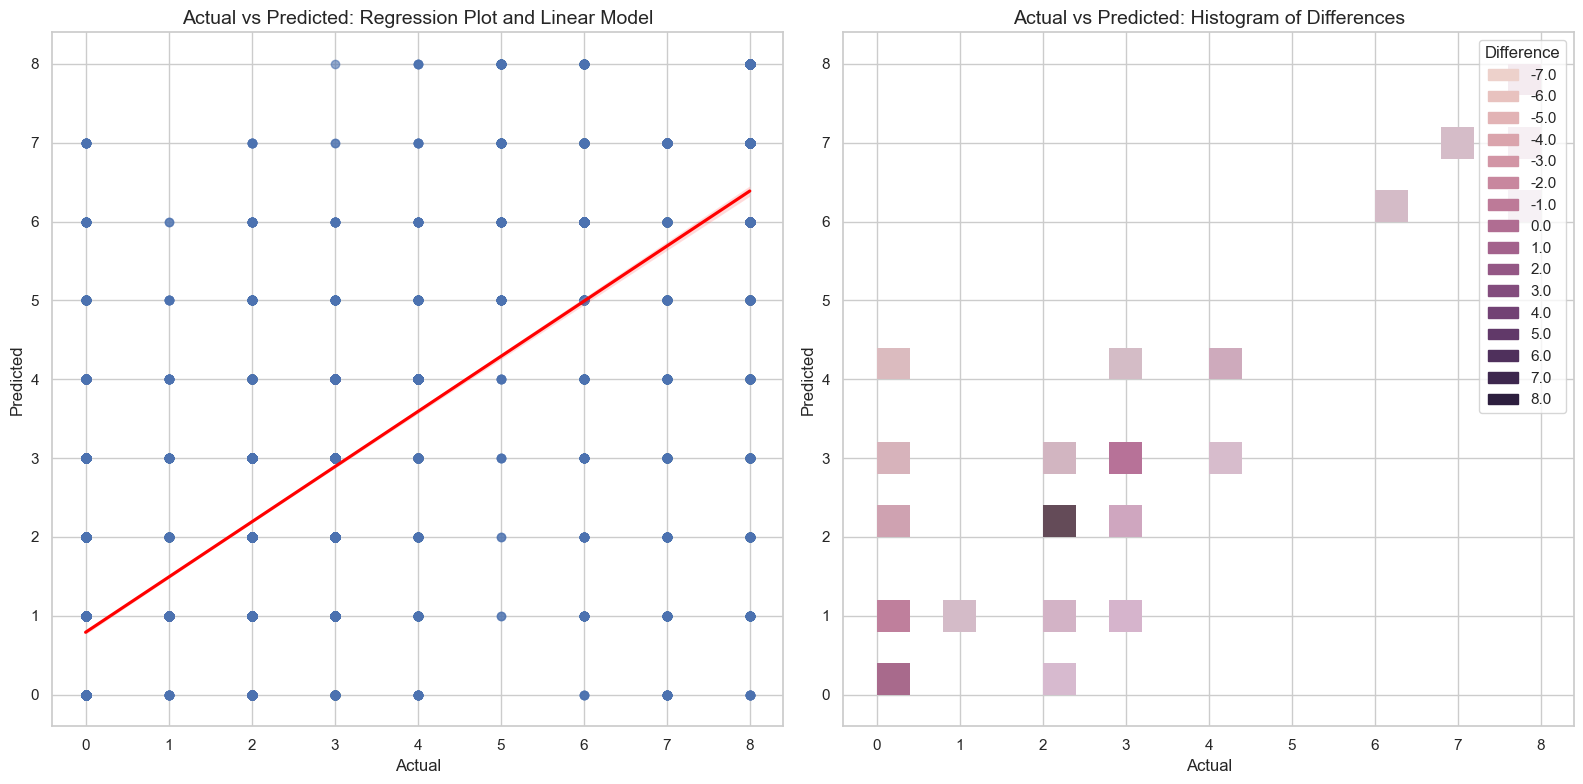

In [24]:
## Visualisations of Preditcted verses Actual
merged = pd.concat([val_y, pd.Series(rf_preds2, index=val_y.index)], axis=1)
merged.columns = ['Actual', 'Predicted']
merged['Difference'] = merged['Actual'] - merged['Predicted']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# First plot: Combined regression plot and scatterplot
sns.regplot(ax=axes[0], x='Actual', y='Predicted', data=merged, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.6})
axes[0].set_title('Actual vs Predicted: Regression Plot and Linear Model', fontsize=14)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Second plot: Histogram or hexbin plot with Difference as hue
sns.histplot(ax=axes[1], data=merged, x='Actual', y='Predicted', hue='Difference', bins=20, pthresh=0.1, cmap='coolwarm')
axes[1].set_title('Actual vs Predicted: Histogram of Differences', fontsize=14)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()

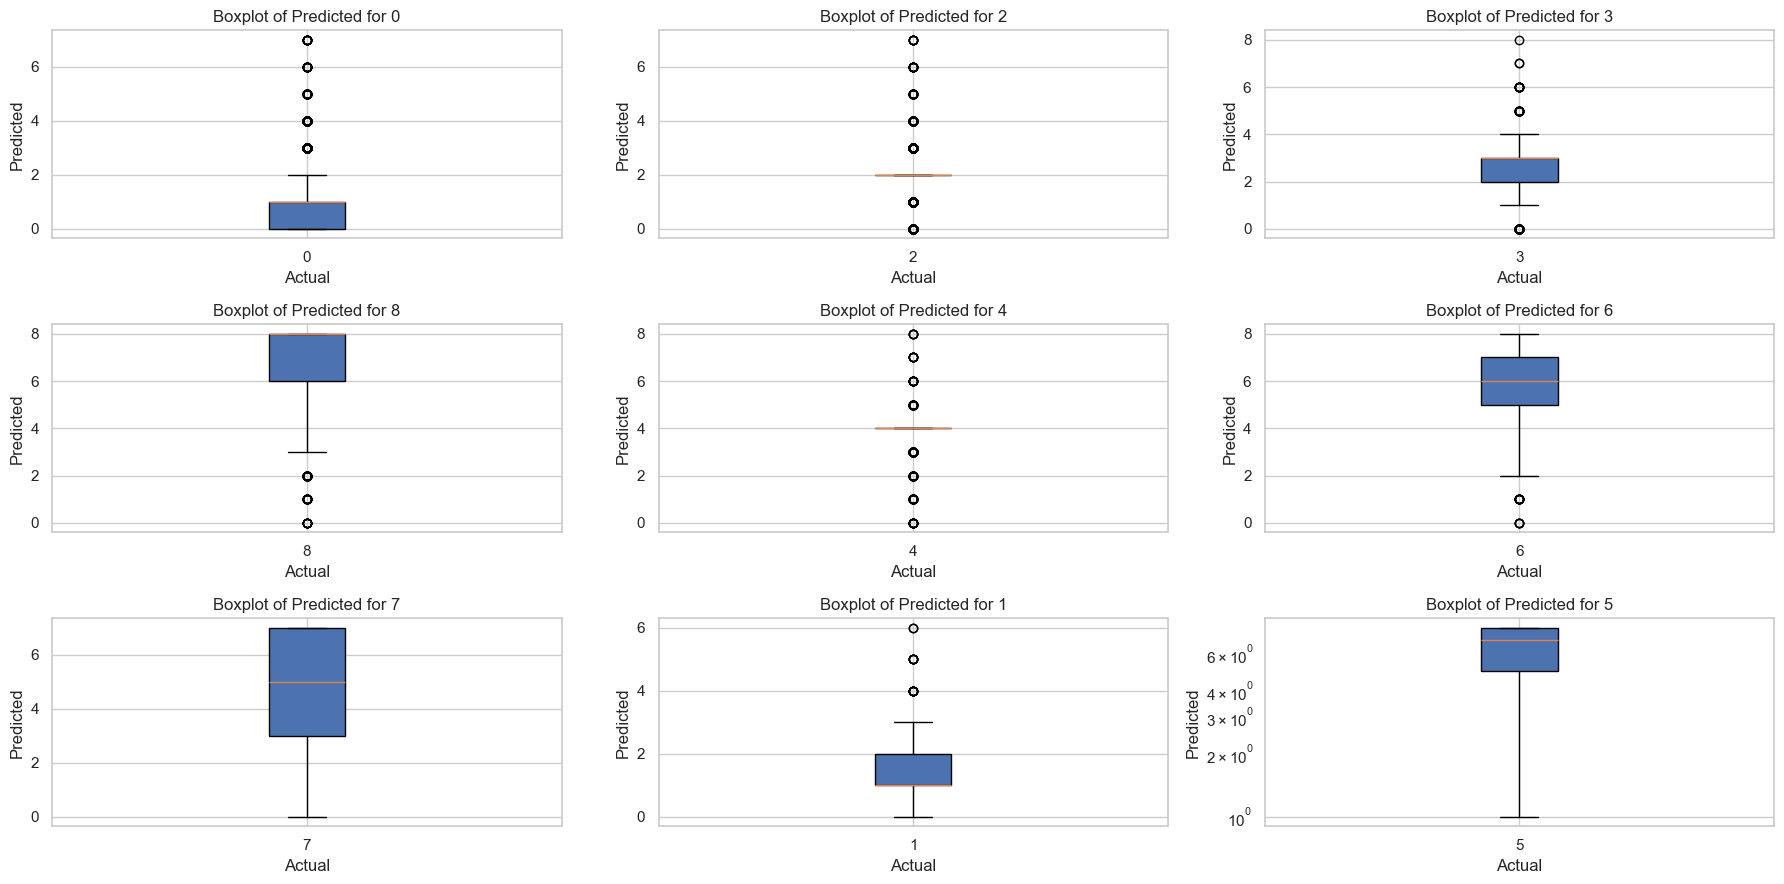

In [25]:
## boxplots of predicted outcomes vs actuals.
generate_boxplots.generate_boxplots(merged, column='Actual', value_column='Predicted')

In [31]:
## Decision Tree Regressor using - Value, MnthsSinceLastElection, Value_Category_code, DonorName_code, DonorStatus_code, DonationType_code, NatureOfDonation_code as Features
model_data = df

# Create Target Object Y
y2= model_data['RegEntity_Group_code']

features2 = ['Value', 'DaysSinceLastElection', 'NatureOfDonation_code']

X2 = model_data[features]
# split into validation and training data
train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y2, random_state=1)

# Specify Model
DonationRecipient = DecisionTreeRegressor()
# Fit Model
DonationRecipient.fit(train_X2, train_y2)

# Make validation predictions and calculate mean absolute error
val_predictions2 = DonationRecipient.predict(val_X2)
val_mae2 = mean_absolute_error(val_predictions2, val_y2)
print("Validation MAE when not specifying max_leaf_nodes: {}".format(val_mae2))
print("MAPE when not specifying max_leaf_nodes: {}".format(val_mae2/val_y2.mean()))

# Using best value for max_leaf_nodes
DonationRecipient = DecisionTreeRegressor(max_leaf_nodes=2000, random_state=1)
DonationRecipient.fit(train_X2, train_y2)
val_predictions3 = DonationRecipient.predict(val_X2)
val_mae3 = mean_absolute_error(val_predictions3, val_y2)
print("Validation MAE for best value of max_leaf_nodes: {}".format(val_mae3))
print("MAPE when max_leaf_nodes = 2000: {}".format(val_mae3/val_y2.mean()))

## Machine learning Model 2 - Random Forest Regressor
# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(train_X2, train_y2)
rf_preds3 = rf_model.predict(val_X2)
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae3 = mean_absolute_error(val_y2, rf_preds3)
print("Validation MAE for Random Forest Model: {}".format(rf_val_mae3))
print("MAPE : {}".format(rf_val_mae3/val_y2.mean()))
## MAE Based on Integerised Predictions.
rf_preds4 = np.floor(0.5 + rf_preds3)
rf_val_mae4 = mean_absolute_error(val_y, rf_preds4)
print("Validation integised MAE for Random Forest Model: {}".format(rf_val_mae4))
print("Integised MAPE : {}".format(rf_val_mae4/val_y2.mean()))

Validation MAE when not specifying max_leaf_nodes: 0.8182997953969735
MAPE when not specifying max_leaf_nodes: 0.3260585852062851
Validation MAE for best value of max_leaf_nodes: 0.9359394776223788
MAPE when max_leaf_nodes = 2000: 0.37293312747831964
Validation MAE for Random Forest Model: 0.789487251392931
MAPE : 0.3145779794588592
Validation integised MAE for Random Forest Model: 0.7546507330294444
Integised MAPE : 0.3006970693633106
